In [1]:
"""
This program takes a list of relative probabilities or frequencies on the
command-line and uses these to construct an optimal binary symbol code with
the Huffman algorithm.

These commands produce the same code:
    python huffman.py 0.1 0.2 0.7
    python huffman.py 100 200 700

This program is written for teaching purposes, and outputs the codes as
human-readable strings rather than packing bits into binary files.
Provided to help explore the results of the Huffman algorithm, not a
demonstration of how to write code!

It is currently left as an exercise for the reader to actually encode and decode
files with the generated symbol code. You could also look at David MacKay's
demonstrations of several compression algorithms:
    http://www.inference.phy.cam.ac.uk/mackay/python/compress/

Iain Murray, October 2011.
"""

INF = 1e999

def min_argmin(array):
    """Returns the minimum element of an array, and its index."""
    mn = min(array)
    return (mn, array.index(mn))

def huffman(probs):
    """Return Huffman codewords for the given probability distribution."""
    nodes = [[x] for x in range(len(probs))]
    merged_probs = probs[:]
    while len(nodes) > 1:
        # find two least probable nodes:
        (mn, idx) = min_argmin(merged_probs)
        merged_probs[idx] = INF
        (mn2, idx2) = min_argmin(merged_probs)
        # merge them:
        merged_probs[idx] = mn + mn2;
        del merged_probs[idx2]
        nodes[idx] = [nodes[idx], nodes[idx2]]
        del nodes[idx2]

    # Recursive navigation of tree of nested lists to construct codes
    def huffman_helper(cur_code, nodes, codes):
        if len(nodes) == 1:
            symbol = nodes[0]
            codes[symbol] = cur_code
        else:
            huffman_helper(cur_code + '0', nodes[0], codes)
            huffman_helper(cur_code + '1', nodes[1], codes)
    codes = ['' for x in range(len(probs))]
    huffman_helper('', nodes[0], codes)
    return codes
    
def symbol_code_expected_length(probs, codes):
    return sum(x*len(y) for (x,y) in zip(probs, codes))

def Hbits(probs):
    """Entropy of discrete distribution, measured in bits."""
    from math import log
    return sum(-x*log(x, 2) for x in probs if x !=0)

a=[10, 20, 300000, 100]
probs = map(float, a)
Z = sum(probs)
probs = [x/Z for x in probs]
codes = huffman(probs)
Lbar = symbol_code_expected_length(probs, codes)
print 'Codewords:'
print '----------'
for cc in codes:
    print cc
print '----------'
print 'Expected length: %g bits/symbol' % Lbar
print 'Entropy of dist: %g bits/symbol' % Hbits(probs)


Codewords:
----------
000
001
1
01
----------
Expected length: 1.00053 bits/symbol
Entropy of dist: 0.0058936 bits/symbol


In [2]:
%matplotlib inline
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.cluster.vq as scv
import pickle
import time

# os.system("cd $CAFFE_ROOT")
caffe_root = os.environ["CAFFE_ROOT"]
os.chdir(caffe_root)
print caffe_root
sys.path.insert(0, caffe_root + 'python')
import caffe

caffe.set_mode_gpu()
caffe.set_device(2)
option = 'alexnet'
if option == 'lenet5':
#     prototxt = '3_prototxt_solver/lenet5/train_val.prototxt'             
    caffemodel = '4_model_checkpoint/lenet5/lenet5.caffemodel'
    solver_proto = '3_prototxt_solver/lenet5/lenet_solver_finetune.prototxt'
    iters = 100
    dir_t = '2_results/kmeans/lenet5/'
elif option == 'alexnet':
    prototxt = '3_prototxt_solver/L2/train_val.prototxt'             
    caffemodel = '4_model_checkpoint/alexnet/alexnet9x.caffemodel'  
    solver_proto = '3_prototxt_solver/L2/finetune_solver.prototxt'
    iters = 1000
    dir_t = '2_results/kmeans/alexnet/'
elif option == 'vgg':
    prototxt = '3_prototxt_solver/vgg16/train_val.prototxt'
    caffemodel = '4_model_checkpoint/vgg16/vgg16_13x.caffemodel'
    solver_proto = '3_prototxt_solver/vgg16/finetune_solver.prototxt'
    snap_dir = '4_model_checkpoint/4_model_checkpoint/vgg16/snapshot/'
    iters = 1000
    dir_t = '2_results/kmeans/vgg16/'

log = dir_t + 'log_accu'
print option

/home/songhan/pruning/
alexnet


In [3]:
solver = caffe.SGDSolver(solver_proto)
solver.net.copy_from(caffemodel)
net = solver.net
conv_bits=8
fc_bits=5
if option=='lenet5':
    layers = ["conv1", "conv2", "ip1", "ip2"]
    num_c = [8, 8, 8, 8]
elif option == 'alexnet':
    layers = filter(lambda x:'conv' in x or 'fc' in x or 'ip' in x, net.params.keys())
    num_c = [2**conv_bits]*5+[2**fc_bits]*3

# layers = ["ip2"]
# num_c =[4]
print "layers TBD: ", layers
print "num_c = ", num_c

layers TBD:  ['conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'fc6', 'fc7', 'fc8']
num_c =  [256, 256, 256, 256, 256, 32, 32, 32]


In [4]:
print "==============1 Perform K-means============="
codebook = {}
for idx, layer in enumerate(layers):
    print "Eval layer:", layer
    W = net.params[layer][0].data.flatten()
    W = W[np.where(W != 0)]
    std = np.std(W)
    initial_uni = np.linspace(np.min(W), np.max(W), num_c[idx]-1)
    codebook[layer],_= scv.kmeans(W, initial_uni)    
    codebook[layer] = np.append(0.0, codebook[layer])
#     print "codebook:", codebook[layer]
    print "codebook size:", len(codebook[layer])

==============1 Perform K-means=============
Eval layer: conv1
codebook size: 215
Eval layer: conv2
codebook size: 194
Eval layer: conv3
codebook size: 172
Eval layer: conv4
codebook size: 159
Eval layer: conv5
codebook size: 189
Eval layer: fc6
codebook size: 31
Eval layer: fc7
codebook size: 28
Eval layer: fc8
codebook size: 32


In [5]:
def quantize(net, layers, use_stochastic=False):
    print "================2 Perform quantization=============="
    codeDict={}
    maskCode={}
    for layer in layers:
        print "Quantize layer:", layer
        W = net.params[layer][0].data
        if use_stochastic:
            codes = stochasitc_quantize2(W.flatten(), codebook[layer])        
        else:
            codes, dist = scv.vq(W.flatten(), codebook[layer])

        W_q = np.reshape(codebook[layer][codes], W.shape)
        net.params[layer][0].data[...] = W_q

        maskCode[layer] = np.reshape(codes, W.shape)
        codeBookSize = len(codebook[layer])    
#         print "W_q.shape=", W_q.shape        
#         print "codebook length=", codeBookSize
#         print "maskcode:", maskCode[layer].flatten().shape
        a = maskCode[layer].flatten()
        b = xrange(len(a))
        codeDict[layer]={}
        for i in xrange(len(a)):
            codeDict[layer].setdefault(a[i], []).append(b[i])

    return codeDict, maskCode

codeDict, maskCode = quantize(net, layers, False)

================2 Perform quantization==============
Quantize layer: conv1
Quantize layer: conv2
Quantize layer: conv3
Quantize layer: conv4
Quantize layer: conv5
Quantize layer: fc6
Quantize layer: fc7
Quantize layer: fc8


conv1
----------
Entropy of dist: 6.27795 bits/symbol
Expected length: 6.30173 bits/symbol
conv2
----------
Entropy of dist: 5.47833 bits/symbol
Expected length: 5.50966 bits/symbol
conv3
----------
Entropy of dist: 5.08304 bits/symbol
Expected length: 5.11326 bits/symbol
conv4
----------
Entropy of dist: 5.18622 bits/symbol
Expected length: 5.20791 bits/symbol
conv5
----------
Entropy of dist: 5.52984 bits/symbol
Expected length: 5.5647 bits/symbol
fc6
----------
Entropy of dist: 3.85235 bits/symbol
Expected length: 3.89572 bits/symbol
fc7
----------
Entropy of dist: 3.5598 bits/symbol
Expected length: 3.58945 bits/symbol
fc8
----------
Entropy of dist: 3.96352 bits/symbol
Expected length: 4.00962 bits/symbol


Total Entropy bits: 3.98590649583
Total Huffman bits: 4.02471658141
Total Original bits: 5.38070096257
Saving: 0.747991127813


Total conv Entropy bits: 5.29127080369
Total conv Huffman bits: 5.31985824576
Total conv Original bits: 8.0


Total fc Entropy bits: 3.79617884679
Tot

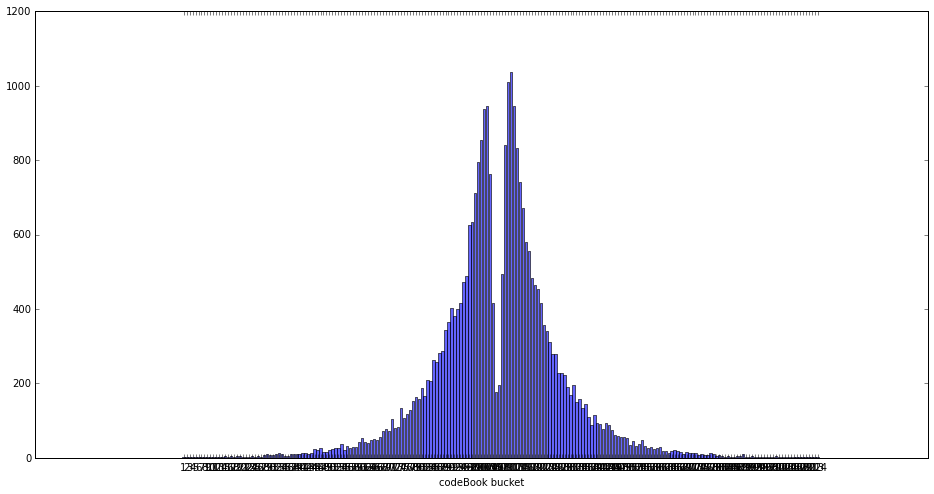

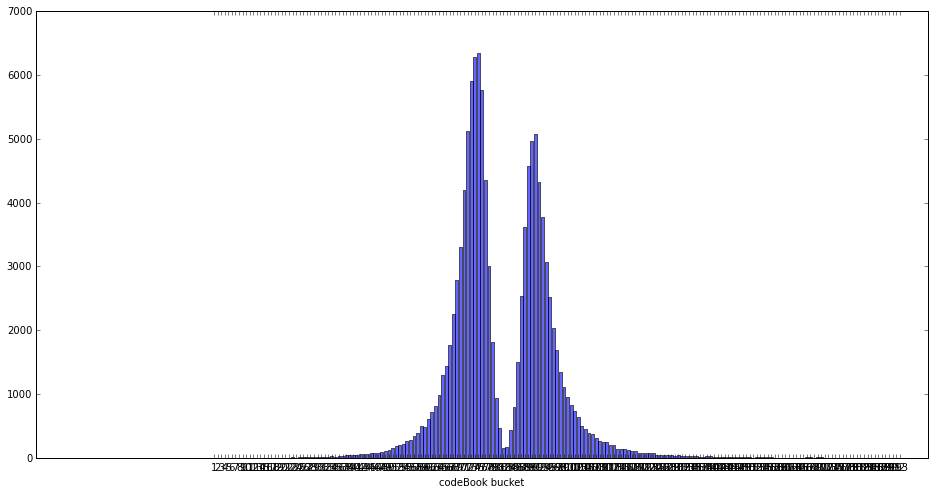

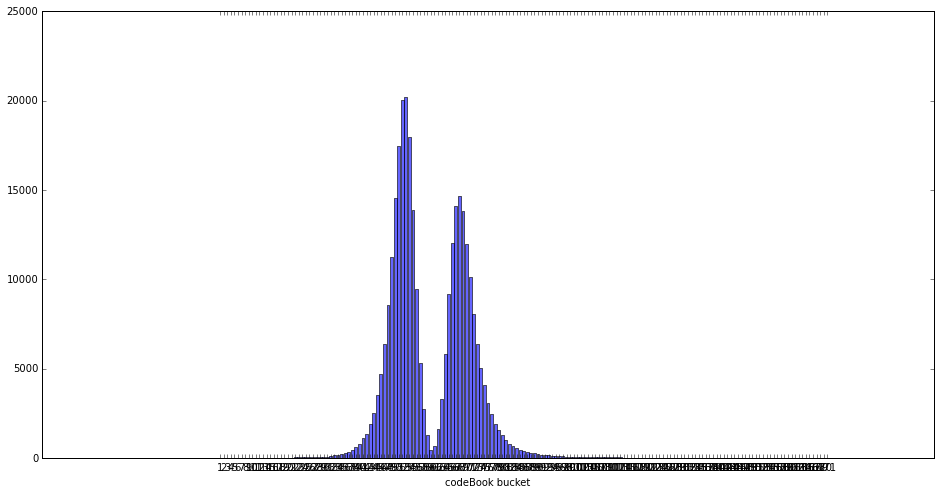

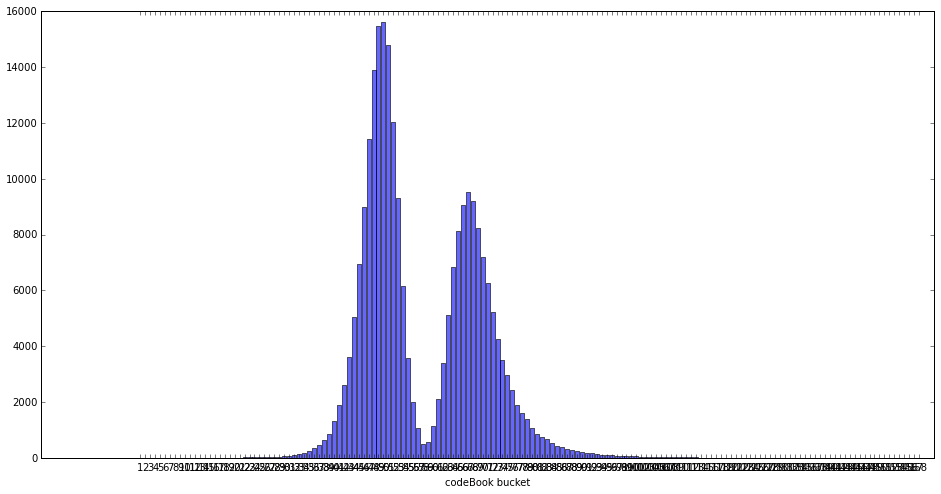

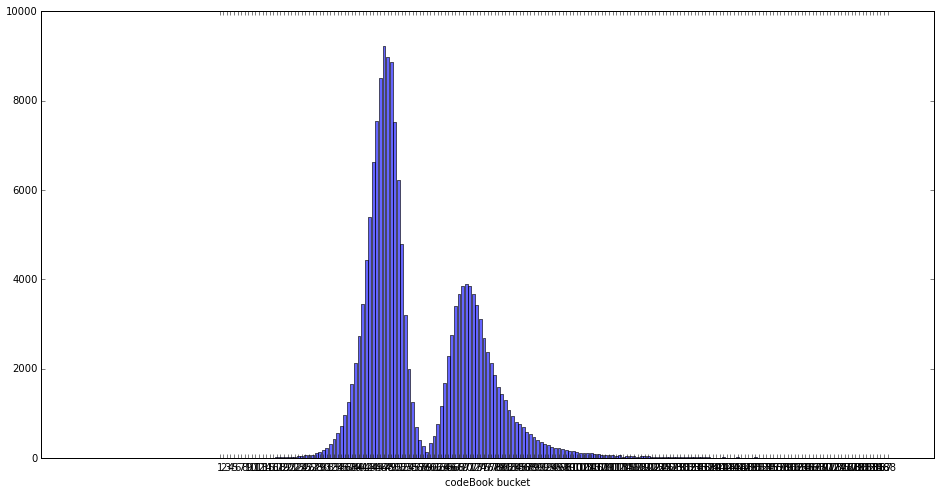

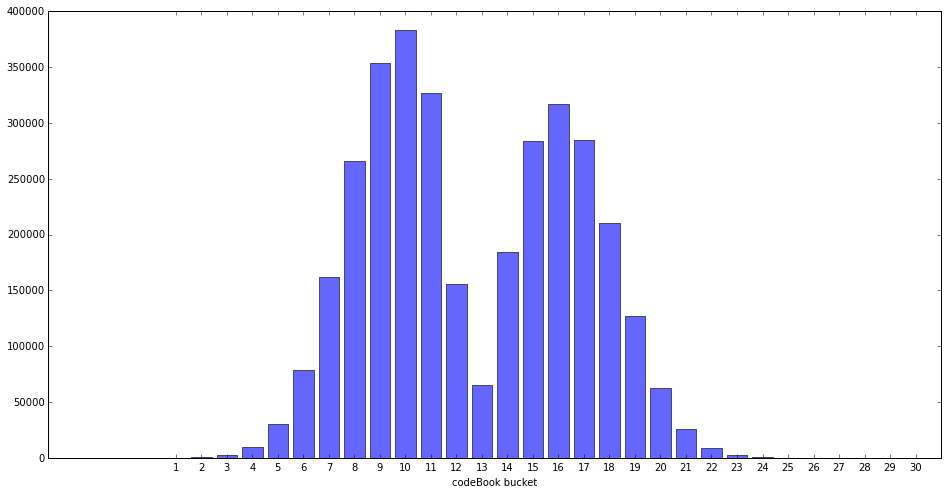

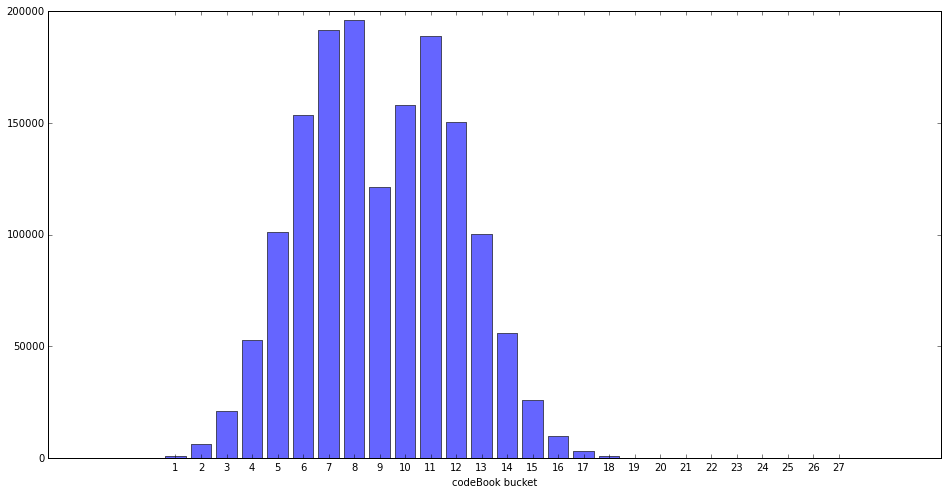

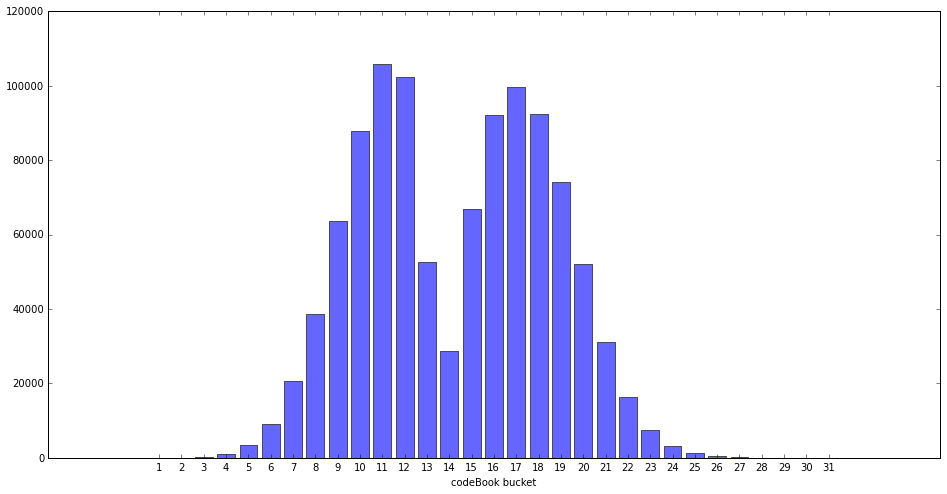

In [7]:
layers = filter(lambda x:'conv' in x or 'fc' in x or 'ip' in x, net.params.keys())
%matplotlib inline
total_Entropy_bits = 0
total_Huffman_bits = 0
total_Original_bits = 0

fc_total_Entropy_bits = 0
fc_total_Huffman_bits = 0
fc_total_Original_bits = 0
fc_total_nz = 0

conv_total_Entropy_bits = 0
conv_total_Huffman_bits = 0
conv_total_Original_bits = 0
conv_total_nz = 0

total_nz = 0
for layer in layers:
    print layer

    plt.figure(figsize=(16,8))
    D= dict([(key, len(codeDict[layer][key])) for key in codeDict[layer].keys() if key!=0])
#     print D
    plt.bar(range(len(D)), D.values(), align='center', alpha=0.6)
    plt.xticks(range(len(D)), D.keys())
    plt.xlabel('codeBook bucket')
    a= [len(codeDict[layer][key]) for key in codeDict[layer].keys() if key!=0]
#     print a
    probs = map(float, a)
    Z = np.sum(probs)
    probs = [x/Z for x in probs]
    codes = huffman(probs)
    Lbar = symbol_code_expected_length(probs, codes)
#     print 'Codewords:'
#     print '----------'
#     for cc in codes:
#         print cc
    total_nz +=Z
    total_Entropy_bits += Hbits(probs)*Z
    total_Huffman_bits += Lbar*Z
    if 'conv' in layer:
        total_Original_bits += conv_bits*Z
        conv_total_Entropy_bits += Hbits(probs)*Z
        conv_total_Huffman_bits += Lbar*Z
        conv_total_Original_bits += conv_bits*Z        
        conv_total_nz +=Z
    if 'fc' in layer:
        total_Original_bits += fc_bits*Z
        fc_total_Entropy_bits += Hbits(probs)*Z
        fc_total_Huffman_bits += Lbar*Z
        fc_total_Original_bits += fc_bits*Z
        fc_total_nz +=Z


    print '----------'
    print 'Entropy of dist: %g bits/symbol' % Hbits(probs)
    print 'Expected length: %g bits/symbol' % Lbar
print '\n'

print 'Total Entropy bits:' , total_Entropy_bits/total_nz
print 'Total Huffman bits:' , total_Huffman_bits/total_nz
print 'Total Original bits:' , total_Original_bits/total_nz
print 'Saving:' , total_Huffman_bits/total_Original_bits
print '\n'

print 'Total conv Entropy bits:' , conv_total_Entropy_bits/conv_total_nz
print 'Total conv Huffman bits:' , conv_total_Huffman_bits/conv_total_nz
print 'Total conv Original bits:' , conv_total_Original_bits/conv_total_nz

print '\n'
print 'Total fc Entropy bits:' , fc_total_Entropy_bits/fc_total_nz
print 'Total fc Huffman bits:' , fc_total_Huffman_bits/fc_total_nz
print 'Total fc Original bits:' , fc_total_Original_bits/fc_total_nz

